# Titanic: Machine Learning from Disaster

### Load raw data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import warnings

sns.set()
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

data = pd.concat([train_data, test_data], ignore_index=True)

In [3]:
def get_train_data(data):
    return data.iloc[:891]

def get_test_data(data):
    return data.iloc[-417:]

#### Features:

## 1. Exploratory data analysis

### 1.1. Overview

##### 1.1.1. Dataset:
- Train: 891 samples, 12 features
- Test: 418 samples, 11 features

##### 1.1.2. Features:
- PassengerId
- Pclass
- Name
- Sex
- Age
- SibSp
- Parch
- Ticket
- Fare
- Cabin
- Embarked
- Survived

##### 1.1.3. Features description:
- ***Pclass***: A proxy for socio-economic status (SES)

1st = Upper, 2nd = Middle, 3rd = Lower

- ***Embarked***: Port of embarkation

C = Cherbourg, Q = Queenstown, S = Southampton

##### 1.1.4. Target:
- Survived

##### 1.1.5. Samples:

In [4]:
train_data.sample(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
418,419,0,2,"Matthews, Mr. William John",male,30.0,0,0,28228,13.0000,NaN,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
412,413,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0000,C78,Q
676,677,0,3,"Sawyer, Mr. Frederick Charles",male,24.5,0,0,342826,8.0500,NaN,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.0,0,0,3101264,6.4958,NaN,S
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C


##### 1.1.6. Data types:

In [5]:
train_data.info()
print('-'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

### 1.2. Missing values:
- `Age`, `Cabin`, `Embarked` are missing in training data
- `Age`, `Cabin`, `Fare` are missing in test data

Even though `Cabin` is missing roughly 80% of its data, but it is an important factor contributing to survival. Because when the ship collided with the iceberg, people was in their cabin. The rate of survival might depend on the range between the cabin and the ship's deck.

##### 1.2.1. Embarked:

In [6]:
data[data['Embarked'].map(lambda a: isinstance(a, float))]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [7]:
data['Embarked'] = data['Embarked'].fillna('S')

##### 1.2.2. Age:
(Based on https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9)

In [8]:
data['Title'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

normalized_titles = {
    'Capt':       'Officer',
    'Col':        'Officer',
    'Major':      'Officer',
    'Jonkheer':   'Royalty',
    'Don':        'Royalty',
    'Sir' :       'Royalty',
    'Dr':         'Officer',
    'Rev':        'Officer',
    'the Countess':'Royalty',
    'Dona':       'Royalty',
    'Mme':        'Mrs',
    'Mlle':       'Miss',
    'Ms':         'Mrs',
    'Mr' :        'Mr',
    'Mrs' :       'Mrs',
    'Miss' :      'Miss',
    'Master' :    'Master',
    'Lady' :      'Royalty'
}

data['Title'] = data['Title'].map(normalized_titles)
data['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

In [9]:
data.Age = data.groupby(['Sex', 'Pclass', 'Title']).Age.apply(lambda x: x.fillna(x.median()))

##### 1.2.3. Cabin:
Put people who don't have cabin value into cabin `M`

In [10]:
data['Deck'] = data['Cabin'].map(lambda x: x[0] if isinstance(x, str) else 'M')

In [11]:
print(data['Deck'].value_counts())

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64


In [12]:
data['Deck'] = data['Deck'].replace('T', 'A')

In [13]:
def calculate_passenger_percent(passengers, total, names, feature='Deck'):
    percentages = []
    
    for e in names:
        percentages.append(100 * len(passengers[feature].loc[lambda x: x == e]) / total[e])
    
    return percentages

def display_deck_population(data):
    upper_psg = data.loc[lambda x: x['Pclass'] == 1]
    middle_psg = data.loc[lambda x: x['Pclass'] == 2]
    lower_psg = data.loc[lambda x: x['Pclass'] == 3]
    
    total = {}
    names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    
    for name in names:
        total[name] = len(data['Deck'].loc[lambda x: x == name])
    
    upper_class = calculate_passenger_percent(upper_psg, total, names)
    middle_class = calculate_passenger_percent(middle_psg, total, names)
    lower_class = calculate_passenger_percent(lower_psg, total, names)

    N = len(names)
    ind = np.arange(N)
    width = 0.45

    p1 = plt.bar(ind, upper_class, width)
    p2 = plt.bar(ind, middle_class, width, bottom=upper_class)
    p3 = plt.bar(ind, lower_class, width, bottom=tuple(map(sum, zip(upper_class, middle_class))))

    plt.ylabel('Percent')
    plt.title('Class rate by deck')
    plt.xticks(ind, names)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend((p1[0], p2[0], p3[0]), ('Upper class', 'Middle class', 'Lower class'))

    plt.show()

def display_embarkation_population(data):
    upper_psg = data.loc[lambda x: x['Pclass'] == 1]
    middle_psg = data.loc[lambda x: x['Pclass'] == 2]
    lower_psg = data.loc[lambda x: x['Pclass'] == 3]
    
    total = {}
    names = ('S', 'C', 'Q')
    
    for name in names:
        total[name] = len(data['Embarked'].loc[lambda x: x == name])
    
    upper_class = calculate_passenger_percent(upper_psg, total, names, 'Embarked')
    middle_class = calculate_passenger_percent(middle_psg, total, names, 'Embarked')
    lower_class = calculate_passenger_percent(lower_psg, total, names, 'Embarked')

    N = len(names)
    ind = np.arange(N)
    width = 0.45

    p1 = plt.bar(ind, upper_class, width)
    p2 = plt.bar(ind, middle_class, width, bottom=upper_class)
    p3 = plt.bar(ind, lower_class, width, bottom=tuple(map(sum, zip(upper_class, middle_class))))

    plt.ylabel('Percent')
    plt.title('Class rate by embarkation')
    plt.xticks(ind, names)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend((p1[0], p2[0], p3[0]), ('Upper class', 'Middle class', 'Lower class'))

    plt.show()
    
def display_deck_survival_rate(data):
    deaths = data.loc[lambda x: x['Survived'] == 0]
    survival = data.loc[lambda x: x['Survived'] == 1]
    
    total = {}
    names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    
    for name in names:
        total[name] = len(data['Deck'].loc[lambda x: x == name])    

    deaths_by_cabin = calculate_passenger_percent(deaths, total, names)
    survival_by_cabin = calculate_passenger_percent(survival, total, names)
    
    N = len(names)
    ind = np.arange(N)
    width = 0.45
    
    p1 = plt.bar(ind, deaths_by_cabin, width)
    p2 = plt.bar(ind, survival_by_cabin, width, bottom=deaths_by_cabin)
    
    plt.ylabel('Percent')
    plt.title('Class rate by deck')
    plt.xticks(ind, names)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend((p1[0], p2[0]), ('Not Survived', 'Survived'))

    plt.show()

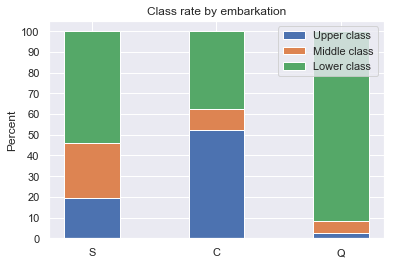

In [14]:
display_embarkation_population(data)

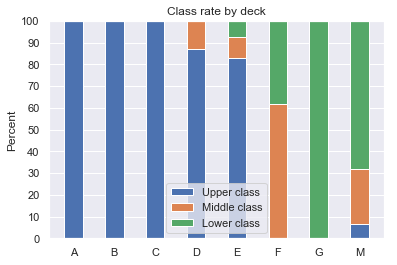

In [15]:
display_deck_population(data)

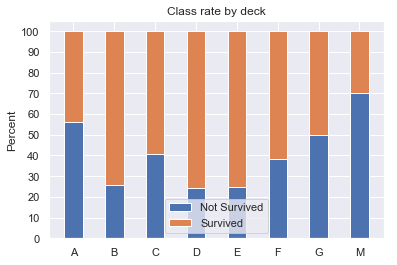

In [16]:
display_deck_survival_rate(get_train_data(data))

In [17]:
data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], 'ABC')
data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')

### 1.3. Target distribution:

In [18]:
ss_train = train_data['Survived'].value_counts() # survival status
train_len = len(train_data)
survival_percents = [
    ss_train[0] / train_len * 100,
    ss_train[1] / train_len * 100
]

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'
      .format(ss_train[1], train_len, survival_percents[0]))

print('{} of {} passengers didn\'t survive and it is the {:.2f}% of the training set.'
      .format(ss_train[0], train_len, survival_percents[1]))

342 of 891 passengers survived and it is the 61.62% of the training set.
549 of 891 passengers didn't survive and it is the 38.38% of the training set.


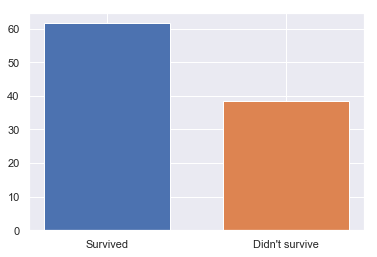

In [19]:
plt.bar(['Survived', 'Didn\'t survive'], survival_percents, width=0.7, color=['#4c72b0', '#dd8451'])
plt.show()

### 1.4. Correlations:

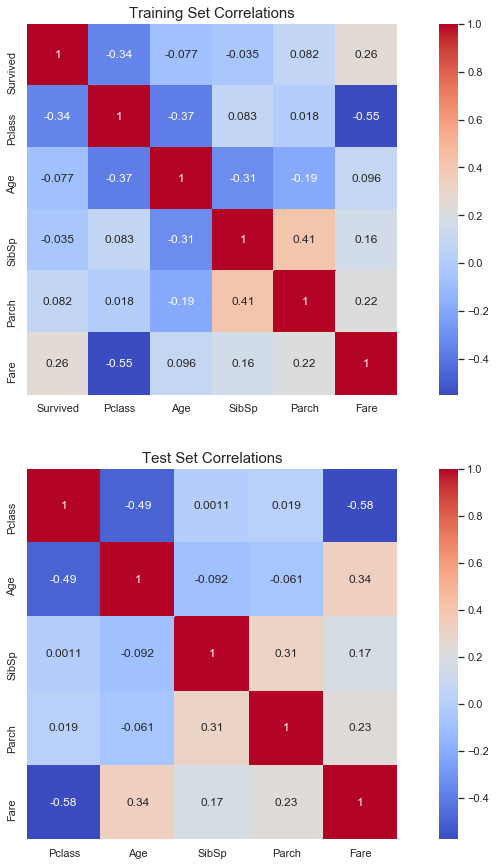

In [20]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm',
                            annot_kws={'size': 12})
sns.heatmap(test_data.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm',
                            annot_kws={'size': 12})
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### 1.5. Target distribution in features:

##### 1.5.1. Continuous features:

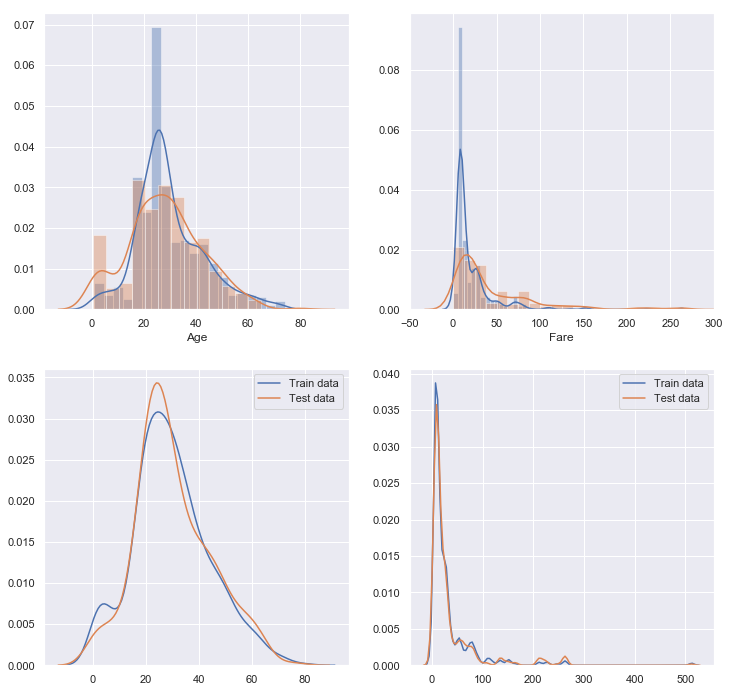

In [21]:
survived = data.loc[lambda x: x['Survived'] == 1]
not_survived = data.loc[lambda x: x['Survived'] == 0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

sns.distplot(not_survived['Age'], ax=axs[0][0])
sns.distplot(survived['Age'], ax=axs[0][0])

sns.distplot(not_survived['Fare'], ax=axs[0][1])
sns.distplot(survived['Fare'], ax=axs[0][1])
axs[0][1].set_xlim([-50, 300])

sns.kdeplot(train_data['Age'], ax=axs[1][0])
sns.kdeplot(test_data['Age'], ax=axs[1][0])

axs[1][0].legend(('Train data', 'Test data'))

sns.kdeplot(train_data['Fare'], ax=axs[1][1])
sns.kdeplot(test_data['Fare'], ax=axs[1][1])

axs[1][0].legend(('Train data', 'Test data'))
axs[1][1].legend(('Train data', 'Test data'))

plt.show()

##### 1.5.2. Categorical features:

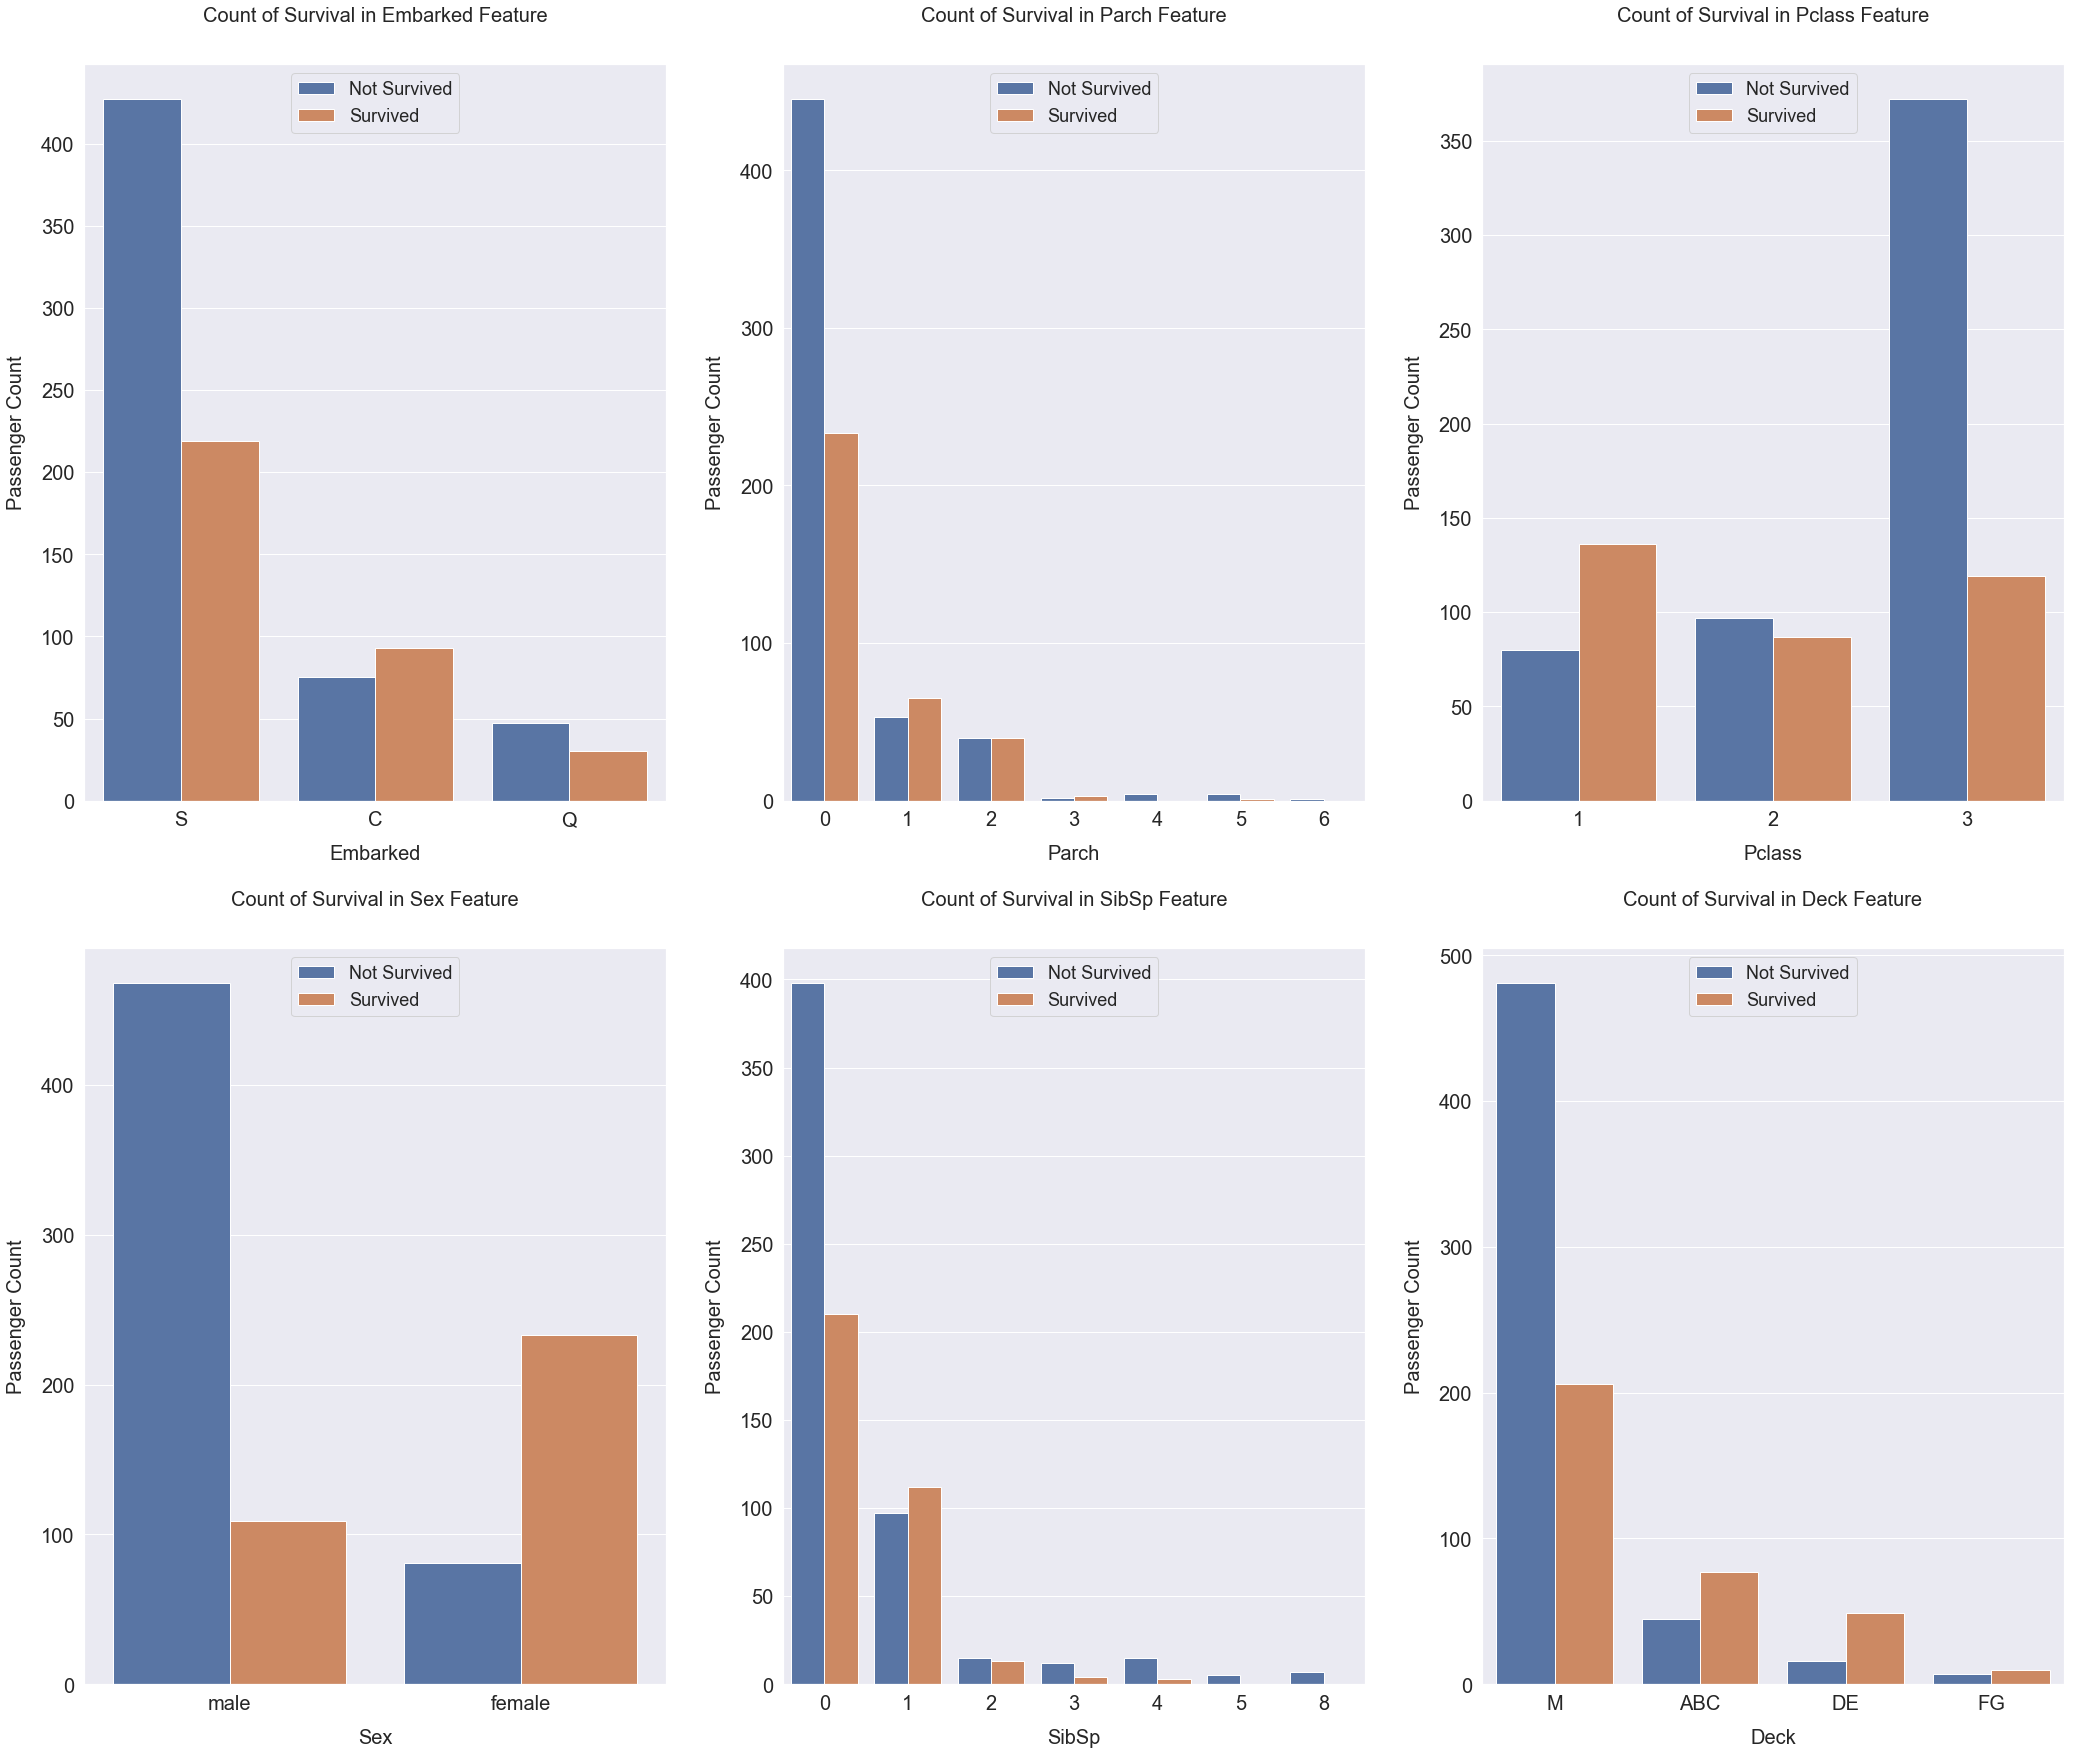

In [22]:
train_data = get_train_data(data)
test_data = get_test_data(data)

cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train_data)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

## 2. Feature Engineering:

### 2.1. Binning Continuous Features

### 2.2. Frequency Encoding

In [25]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [26]:
data['FamilySize'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64

In [27]:
family_sizes = {
    1: 'Alone',
    2: 'Small',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Large',
    8: 'Large',
    11: 'Large',
}
data['FamilySizeGrouped'] = data['FamilySize'].map(family_sizes)

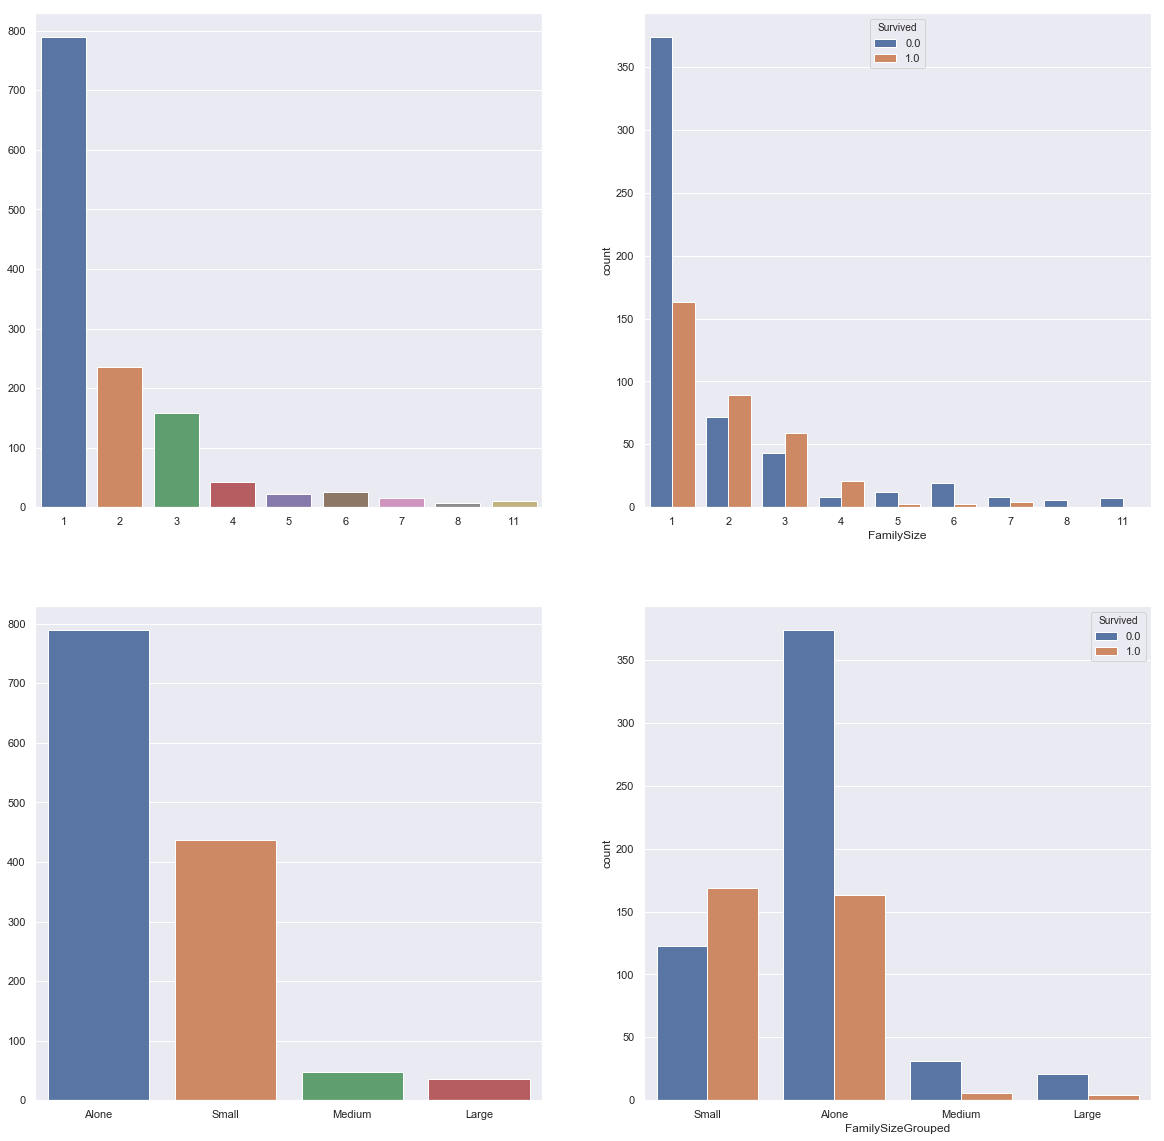

In [53]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

sns.barplot(x=data['FamilySize'].value_counts().index, y=data['FamilySize'].value_counts().values, ax=axs[0][0])
sns.countplot(x='FamilySize', hue='Survived', data=data, ax=axs[0][1])

sns.barplot(x=data['FamilySizeGrouped'].value_counts().index, y=data['FamilySizeGrouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='FamilySizeGrouped', hue='Survived', data=data, ax=axs[1][1])
plt.show()
# for i, feature in enumerate(cat_features, 1):    
#     plt.subplot(2, 3, i)
#     sns.countplot(x=feature, hue='Survived', data=train_data)
    
#     plt.xlabel('{}'.format(feature), size=20, labelpad=15)
#     plt.ylabel('Passenger Count', size=20, labelpad=15)    
#     plt.tick_params(axis='x', labelsize=20)
#     plt.tick_params(axis='y', labelsize=20)
    
#     plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
#     plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

# plt.show()

In [56]:
data['TicketFrequency'] = data.groupby('Ticket')['Ticket'].transform('count')

In [57]:
data['TicketFrequency'].value_counts()

1     713
2     264
3     147
4      64
7      35
5      35
6      24
8      16
11     11
Name: TicketFrequency, dtype: int64